### **<center> <h2><strong>Entrenamiento de un modelo de clasificación para las fases de maduración del cacao</strong></h2> </center>**

Este notebook documenta el proceso de entrenamiento de un modelo de Transfer Learning basado en ResNet50 para clasificar imágenes en cuatro categorías.

In [51]:
# Se instalan librerías
%pip install torch torchvision matplotlib pandas opencv-python tqdm


Note: you may need to restart the kernel to use updated packages.


In [52]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


### **Carga y procesamiento de datos**

**Carga del dataset**

Se carga un dataset estructurado en formato COCO, el cual contiene imágenes organizadas en cuatro carpetas (images_C1, images_C2, images_C3, images_C4), cada una representando una fase de maduración del cacao.

Se realiza la verificación de la integridad del dataset:
Total de imágenes: 3,989

Distribución por clase:
images_C1: 999 imágenes
images_C2: 1000 imágenes
images_C3: 1000 imágenes
images_C4: 990 imágenes

Se dividen los datos en entrenamiento, validación y prueba con las siguientes proporciones:
Entrenamiento: 70% (2,795 imágenes)
Validación: 15% (597 imágenes)
Prueba: 15% (597 imágenes)


In [53]:
import os
import json
import pandas as pd
import numpy as np
from PIL import Image

def load_custom_dataset(base_path, folder_names):
    """
    Carga datasets COCO desde la estructura específica de carpetas.
    
    Parameters:
    base_path (str): Ruta base donde se encuentran las carpetas de imágenes.
    folder_names (list): Lista de nombres de carpetas (images_C1, images_C2, etc.).
    
    Returns:
    pandas.DataFrame: DataFrame consolidado con toda la información.
    """
    all_image_data = []
    
    # Imprimir las rutas para depuración
    print(f"Ruta base: {base_path}")
    print("Carpetas a procesar:", folder_names)
    
    for folder_name in folder_names:
        # Construir rutas
        images_path = os.path.join(base_path, folder_name)
        annotation_path = os.path.join(base_path, f'{folder_name}.json')
        
        print(f"\nProcesando carpeta: {folder_name}")
        print(f"Ruta de imágenes: {images_path}")
        print(f"Ruta de anotaciones: {annotation_path}")
        
        try:
            # Verificar si el archivo JSON existe
            if not os.path.exists(annotation_path):
                print(f"¡Advertencia! No se encontró el archivo: {annotation_path}")
                continue
                
            # Cargar archivo JSON
            with open(annotation_path, 'r') as f:
                coco_data = json.load(f)
            
            print(f"JSON cargado exitosamente para {folder_name}")
            
            # Crear diccionario de categorías
            categories = {cat['id']: cat['name'] for cat in coco_data['categories']}
            
            # Crear diccionario de imágenes
            images = {img['id']: img for img in coco_data['images']}
            
            # Organizar anotaciones por imagen
            image_annotations = {}
            for ann in coco_data['annotations']:
                img_id = ann['image_id']
                if img_id not in image_annotations:
                    image_annotations[img_id] = set()
                image_annotations[img_id].add(categories[ann['category_id']])
            
            # Obtener el número de clase del nombre de la carpeta
            class_number = int(folder_name.split('_C')[1])
            
            # Preparar datos para el DataFrame
            for img_id, annotations in image_annotations.items():
                img_info = images[img_id]
                
                # Corregir ruta de la imagen
                img_filename = os.path.basename(img_info['file_name'])  # Asegurar que solo sea el nombre del archivo
                image_entry = {
                    'image_id': img_id,
                    'file_name': img_filename,
                    'path': os.path.normpath(os.path.join(base_path, folder_name, img_filename)),  # Construcción corregida
                    'width': img_info.get('width', None),
                    'height': img_info.get('height', None),
                    'categories': list(annotations),
                    'class_name': folder_name,  # Guardamos el nombre de la carpeta
                    'class_number': class_number  # Guardamos el número de clase
                }
                all_image_data.append(image_entry)
            
            print(f"Procesadas {len(image_annotations)} imágenes de {folder_name}")
                
        except Exception as e:
            print(f"Error procesando {folder_name}: {str(e)}")
    
    # Crear DataFrame consolidado
    if not all_image_data:
        raise ValueError("No se encontraron datos en ninguna carpeta")
    
    df = pd.DataFrame(all_image_data)
    return df



**Transformaciones y DataLoaders**

Se aplican transformaciones de preprocesamiento a las imágenes:

Redimensionamiento: (224x224)
Flip horizontal aleatorio

Rotación aleatoria (15 grados)

Normalización ([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])

Los datos son cargados en DataLoaders con batch_size=32, permitiendo un procesamiento eficiente en GPU.

In [54]:
def create_train_val_test_split(df, val_size=0.15, test_size=0.15, seed=42):
    """
    Crea splits estratificados manteniendo la distribución de clases.
    """
    np.random.seed(seed)
    
    train_data, val_data, test_data = [], [], []
    
    # Procesar por clase
    for class_name in df['class_name'].unique():
        class_data = df[df['class_name'] == class_name]
        
        # Calcular tamaños
        n_samples = len(class_data)
        n_test = int(n_samples * test_size)
        n_val = int(n_samples * val_size)
        
        # Dividir los datos
        shuffled = class_data.sample(frac=1, random_state=seed)
        train_data.append(shuffled[:(n_samples-n_test-n_val)])
        val_data.append(shuffled[(n_samples-n_test-n_val):(n_samples-n_test)])
        test_data.append(shuffled[(n_samples-n_test):])
    
    # Combinar los datos
    train_df = pd.concat(train_data).reset_index(drop=True)
    val_df = pd.concat(val_data).reset_index(drop=True)
    test_df = pd.concat(test_data).reset_index(drop=True)
    
    return train_df, val_df, test_df

def verify_dataset(df):
    """
    Verifica la integridad del dataset.
    """
    verification = {
        'total_images': len(df),
        'images_per_class': df['class_name'].value_counts().to_dict(),
        'missing_images': [],
        'categories_per_class': {}
    }
    
    # Verificar que las imágenes existen
    for idx, row in df.iterrows():
        if not os.path.exists(row['path']):
            verification['missing_images'].append(row['path'])
    
    # Analizar categorías por clase
    for class_name in df['class_name'].unique():
        class_data = df[df['class_name'] == class_name]
        categories = [cat for cats in class_data['categories'] for cat in cats]
        verification['categories_per_class'][class_name] = pd.Series(categories).value_counts().to_dict()
    
    return verification

In [55]:
# 1. Definir las rutas
ruta_1 = 'C:\\Users\\melis\\Desktop\\Proyecto_Cocoa\\Proyecto_Cocoa_2025\\Proyecto\\Pruebas\\RipSetCocoaCNCH12\\COCO_10'
ruta_2 = ['images_C1', 'images_C2', 'images_C3', 'images_C4']

# 2. Cargar el dataset
try:
    df = load_custom_dataset(ruta_1, ruta_2)
    
    # 3. Verificar la integridad del dataset
    verification = verify_dataset(df)
    print("\nEstadísticas del dataset:")
    print(f"Total de imágenes: {verification['total_images']}")
    print("\nImágenes por clase:")
    for class_name, count in verification['images_per_class'].items():
        print(f"{class_name}: {count}")

    if verification['missing_images']:
        print("\n¡Advertencia! Imágenes faltantes:", len(verification['missing_images']))

    # 4. Crear los splits
    train_df, val_df, test_df = create_train_val_test_split(df)

    # 5. Ver distribución final
    print("\nDistribución final:")
    print(f"Train: {len(train_df)} imágenes")
    print(f"Validación: {len(val_df)} imágenes")
    print(f"Test: {len(test_df)} imágenes")

except Exception as e:
    print(f"Error en el proceso: {str(e)}")

Ruta base: C:\Users\melis\Desktop\Proyecto_Cocoa\Proyecto_Cocoa_2025\Proyecto\Pruebas\RipSetCocoaCNCH12\COCO_10
Carpetas a procesar: ['images_C1', 'images_C2', 'images_C3', 'images_C4']

Procesando carpeta: images_C1
Ruta de imágenes: C:\Users\melis\Desktop\Proyecto_Cocoa\Proyecto_Cocoa_2025\Proyecto\Pruebas\RipSetCocoaCNCH12\COCO_10\images_C1
Ruta de anotaciones: C:\Users\melis\Desktop\Proyecto_Cocoa\Proyecto_Cocoa_2025\Proyecto\Pruebas\RipSetCocoaCNCH12\COCO_10\images_C1.json
JSON cargado exitosamente para images_C1
Procesadas 999 imágenes de images_C1

Procesando carpeta: images_C2
Ruta de imágenes: C:\Users\melis\Desktop\Proyecto_Cocoa\Proyecto_Cocoa_2025\Proyecto\Pruebas\RipSetCocoaCNCH12\COCO_10\images_C2
Ruta de anotaciones: C:\Users\melis\Desktop\Proyecto_Cocoa\Proyecto_Cocoa_2025\Proyecto\Pruebas\RipSetCocoaCNCH12\COCO_10\images_C2.json
JSON cargado exitosamente para images_C2
Procesadas 1000 imágenes de images_C2

Procesando carpeta: images_C3
Ruta de imágenes: C:\Users\melis

In [56]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import json
import torch
import torchvision.transforms as transforms

class CocoaDataset(Dataset):
    def __init__(self, df, base_path, transform=None):
        self.df = df
        self.base_path = base_path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['image_path'])
        image = Image.open(img_path).convert("RGB")
        label = row['label']

        if self.transform:
            image = self.transform(image)

        return image, label

# Transformaciones de preprocesamiento
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# Directorio base donde están las imágenes
base_path = "C:\\Users\\melis\\Desktop\\Proyecto_Cocoa\\Proyecto_Cocoa_2025\\Proyecto\\Pruebas\\RipSetCocoaCNCH12\\COCO_10"

# Crear datasets de entrenamiento, validación y prueba
train_dataset = CocoaDataset(train_df, base_path, transform)
val_dataset = CocoaDataset(val_df, base_path, transform)
test_dataset = CocoaDataset(test_df, base_path, transform)

# Crear DataLoaders
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"DataLoaders listos: {len(train_loader)} batches de entrenamiento")


DataLoaders listos: 88 batches de entrenamiento


### **Preparación del modelo**

Se utiliza ResNet50 preentrenado en ImageNet y se realiza fine-tuning en las últimas capas:

Se congelan todas las capas excepto las últimas 4 capas y fc.

Se modifica la última capa (fc) para clasificar en 4 categorías.

In [57]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar modelo preentrenado
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

# Congelar todas las capas
for param in model.parameters():
    param.requires_grad = False

# Descongelar las últimas 4 capas + capa final (fc)
for name, param in model.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:  
        param.requires_grad = True

# Reemplazar la última capa de clasificación
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 4)

# Mover modelo a GPU si está disponible
model = model.to(device)

# Definir función de pérdida y optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.0001)

print("Configuración lista: Capas base congeladas excepto las últimas 4 capas y fc.")


Configuración lista: Capas base congeladas excepto las últimas 4 capas y fc.


Se hacen algunos ajustes para coincidir los nombres de los datos del df

In [58]:
train_df.rename(columns={"path": "image_path"}, inplace=True)
val_df.rename(columns={"path": "image_path"}, inplace=True)
test_df.rename(columns={"path": "image_path"}, inplace=True)



In [59]:
train_df.rename(columns={"class_number": "label"}, inplace=True)
val_df.rename(columns={"class_number": "label"}, inplace=True)
test_df.rename(columns={"class_number": "label"}, inplace=True)


In [60]:
train_df["label"] = train_df["label"] - 1
val_df["label"] = val_df["label"] - 1
test_df["label"] = test_df["label"] - 1


In [61]:
print("Clases corregidas:", train_df["label"].unique())  # Debe mostrar [0, 1, 2, 3]


Clases corregidas: [0 1 2 3]


### **Entrenamiento del modelo**

Se entrena el modelo por 6 épocas, registrando la pérdida (loss) y la precisión (accuracy) en cada iteración. Se escoge al final esta cantidad de épocas, ya que se analizó con un mayor número, pero llegaba a resultados muy buenos en las primeras épocas.

In [62]:
num_epochs = 6

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in tqdm(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    train_acc = 100. * correct / total

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Evaluación en validación
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total_val += labels.size(0)
            correct_val += predicted.eq(labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100. * correct_val / total_val

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Época {epoch+1}/{num_epochs} - Pérdida: {train_loss:.4f} - Precisión: {train_acc:.2f}% | Validación - Pérdida: {val_loss:.4f} - Precisión: {val_acc:.2f}%")


100%|██████████| 88/88 [12:54<00:00,  8.80s/it]


Época 1/6 - Pérdida: 0.6731 - Precisión: 75.24% | Validación - Pérdida: 0.2769 - Precisión: 89.45%


100%|██████████| 88/88 [13:18<00:00,  9.07s/it]


Época 2/6 - Pérdida: 0.2592 - Precisión: 89.98% | Validación - Pérdida: 0.2173 - Precisión: 92.80%


100%|██████████| 88/88 [12:56<00:00,  8.82s/it]


Época 3/6 - Pérdida: 0.1618 - Precisión: 94.03% | Validación - Pérdida: 0.2048 - Precisión: 91.46%


100%|██████████| 88/88 [13:01<00:00,  8.89s/it]


Época 4/6 - Pérdida: 0.1191 - Precisión: 95.74% | Validación - Pérdida: 0.1473 - Precisión: 94.47%


100%|██████████| 88/88 [12:55<00:00,  8.82s/it]


Época 5/6 - Pérdida: 0.0835 - Precisión: 97.32% | Validación - Pérdida: 0.1565 - Precisión: 94.97%


100%|██████████| 88/88 [12:56<00:00,  8.83s/it]


Época 6/6 - Pérdida: 0.0590 - Precisión: 98.25% | Validación - Pérdida: 0.1756 - Precisión: 93.47%


**Observaciones:**

La precisión en entrenamiento supera el 98% en la última época.

La precisión en validación alcanza un 94.97%, mostrando una buena generalización.

La pérdida en validación oscila, lo que indica que el modelo podría tener técnicas adicionales para evitar sobreajuste.



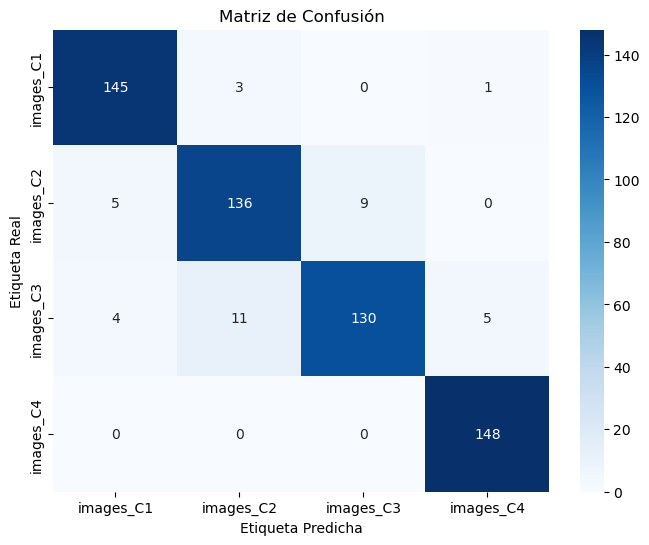

Classification Report:
               precision    recall  f1-score   support

   images_C1       0.94      0.97      0.96       149
   images_C2       0.91      0.91      0.91       150
   images_C3       0.94      0.87      0.90       150
   images_C4       0.96      1.00      0.98       148

    accuracy                           0.94       597
   macro avg       0.94      0.94      0.94       597
weighted avg       0.94      0.94      0.94       597



In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Función para evaluar el modelo
def evaluate_model(model, dataloader, class_names):
    model.eval()  # Modo evaluación
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    # Matriz de confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Etiqueta Predicha")
    plt.ylabel("Etiqueta Real")
    plt.title("Matriz de Confusión")
    plt.show()

    # Reporte de clasificación con precisión, recall y F1-score
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("Classification Report:\n", report)

# Definir nombres de clases según tu problema
class_names = ["images_C1", "images_C2", "images_C3", "images_C4"]  # Ajusta según tus clases reales

# Evaluar el modelo
evaluate_model(model, val_loader, class_names)


### **Evaluación del modelo**

Se generan métricas de evaluación en el conjunto de validación:

**Matriz de confusión**

Se visualiza la matriz de confusión para analizar el rendimiento del modelo en cada clase.

**Reporte de la clasificación**

Precisión promedio: 94%

Recall promedio: 94%

F1-score promedio: 94%

El modelo muestra un muy buen desempeño en todas las clases, con valores superiores al 90% en todas las métricas clave.



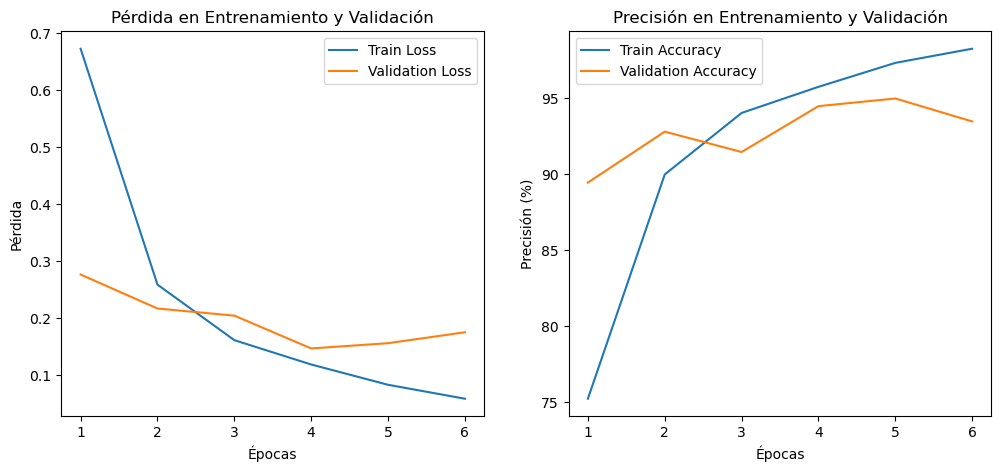

In [64]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(12, 5))

# Gráfica de pérdida
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Pérdida en Entrenamiento y Validación")
plt.legend()

# Gráfica de precisión
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label="Train Accuracy")
plt.plot(epochs, val_accuracies, label="Validation Accuracy")
plt.xlabel("Épocas")
plt.ylabel("Precisión (%)")
plt.title("Precisión en Entrenamiento y Validación")
plt.legend()

plt.show()


In [65]:
torch.save(model.state_dict(), "modelo_cacao_resnet50_finetuned_2.pth")
print("Modelo guardado con las últimas 4 capas entrenadas.")

Modelo guardado con las últimas 4 capas entrenadas.


### **Conclusiones**

El modelo demuestra un alto nivel de precisión (94.97%), con un buen balance entre las clases y un rendimiento estable en la validación. La F1-score promedio es del 94%, lo que indica que el modelo logra un equilibrio entre precisión y recall.
Siendo altamente efectivo para la clasificación de imágenes en las distintas etapas de maduración del cacao y estaría listo para su implementación o pruebas en entornos reales y así evaluar mejor su comportamiento.

**Recomendaciones para mejorar el modelo**

Incluir más técnicas de data augmentation para mejorar la estabilidad del modelo, implementar técnicas como Dropout para minimizar el sobreajuste y evaluar el modelo con imágenes fuera del dataset para analizar su capacidad de generalización.

